# Projet du cours de Machine Learning : analyse du dataset d'OpenFoodFact

## Chargement des données 

### A partir du format csv

In [1]:
# Import libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sys.path.append("C:/Users/jaech/OneDrive/Documents/cours/teaching_ml_bis_2025/scripts")

from filter import filter_data
from outliers import detect_outliers_ransac
from kmeans import train_kmeans

In [2]:
path = "https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv.gz"
df = pd.read_csv(path, nrows=100, sep='\t',encoding="utf-8")

In [3]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 206 columns):
 #    Column                                                 Dtype  
---   ------                                                 -----  
 0    code                                                   int64  
 1    url                                                    object 
 2    creator                                                object 
 3    created_t                                              int64  
 4    created_datetime                                       object 
 5    last_modified_t                                        int64  
 6    last_modified_datetime                                 object 
 7    last_modified_by                                       object 
 8    last_updated_t                                         int64  
 9    last_updated_datetime                                  object 
 10   product_name                                           object

In [4]:
# call filter on df
df = filter_data(df)
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 187 columns):
 #    Column                                                 Dtype   
---   ------                                                 -----   
 0    code                                                   int16   
 1    creator                                                category
 2    created_t                                              int32   
 3    last_modified_t                                        int32   
 4    last_modified_by                                       category
 5    last_updated_t                                         int32   
 6    abbreviated_product_name                               float32 
 7    generic_name                                           category
 8    quantity                                               category
 9    packaging                                              category
 10   packaging_tags                                   

Total number of outliers detected: 13
Percentage of outliers: 13.00%


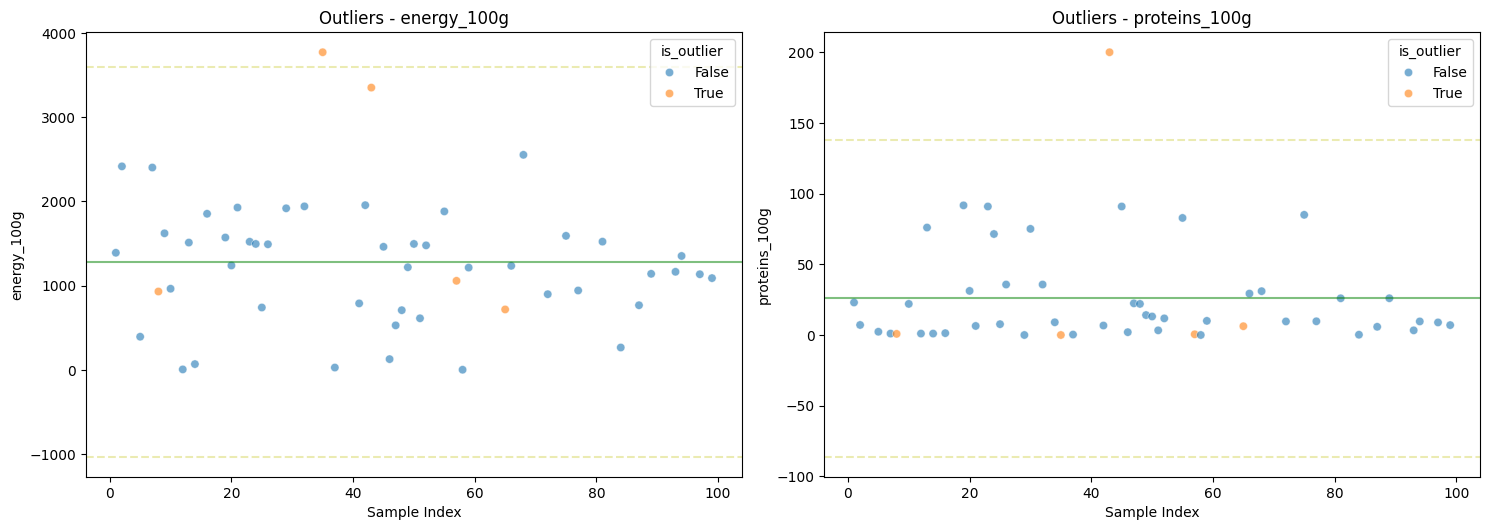


Outlier percentages by column:
code: 1.00%
created_t: 0.00%
last_modified_t: 1.00%
last_updated_t: 4.00%
serving_quantity: 1.75%
additives_n: 0.00%
product_quantity: 3.12%
unique_scans_n: 1.25%
completeness: 0.00%
last_image_t: 1.00%
energy_100g: 1.96%
proteins_100g: 1.96%
fruits-vegetables-nuts-estimate-from-ingredients_100g: 3.70%


In [5]:
# detect outliers avec RANSAC
df_ransac, ransac_models, outlier_percentages = detect_outliers_ransac(df)

# print outlier % pour chaque col
print("\nOutlier percentages by column:")
for col, pct in outlier_percentages.items():
    print(f"{col}: {pct:.2f}%")


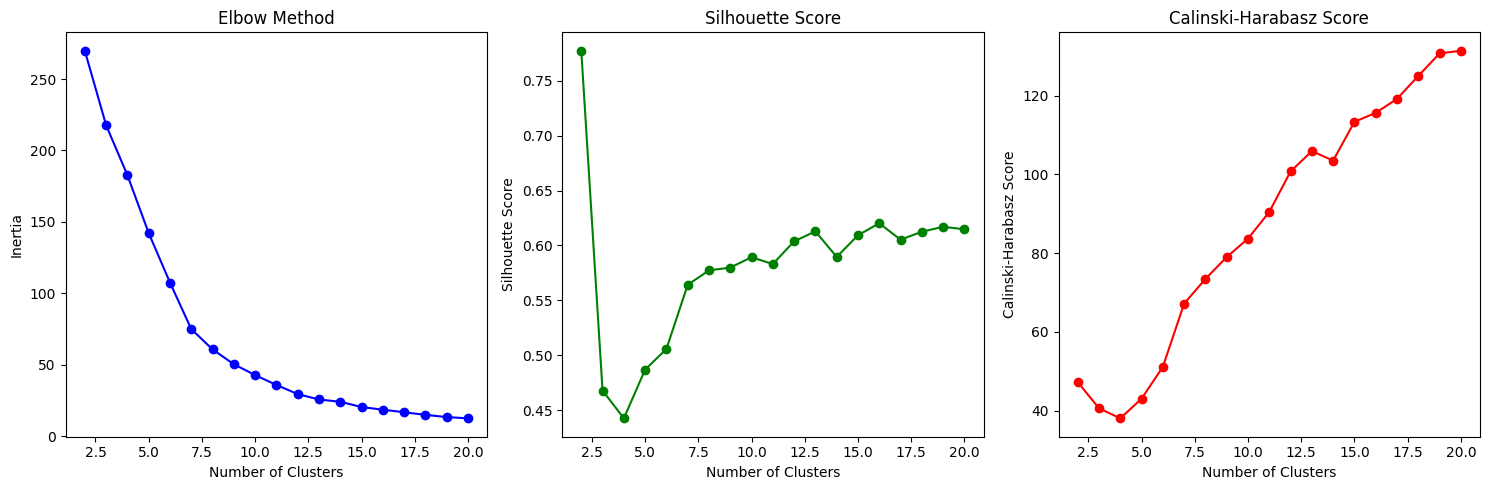

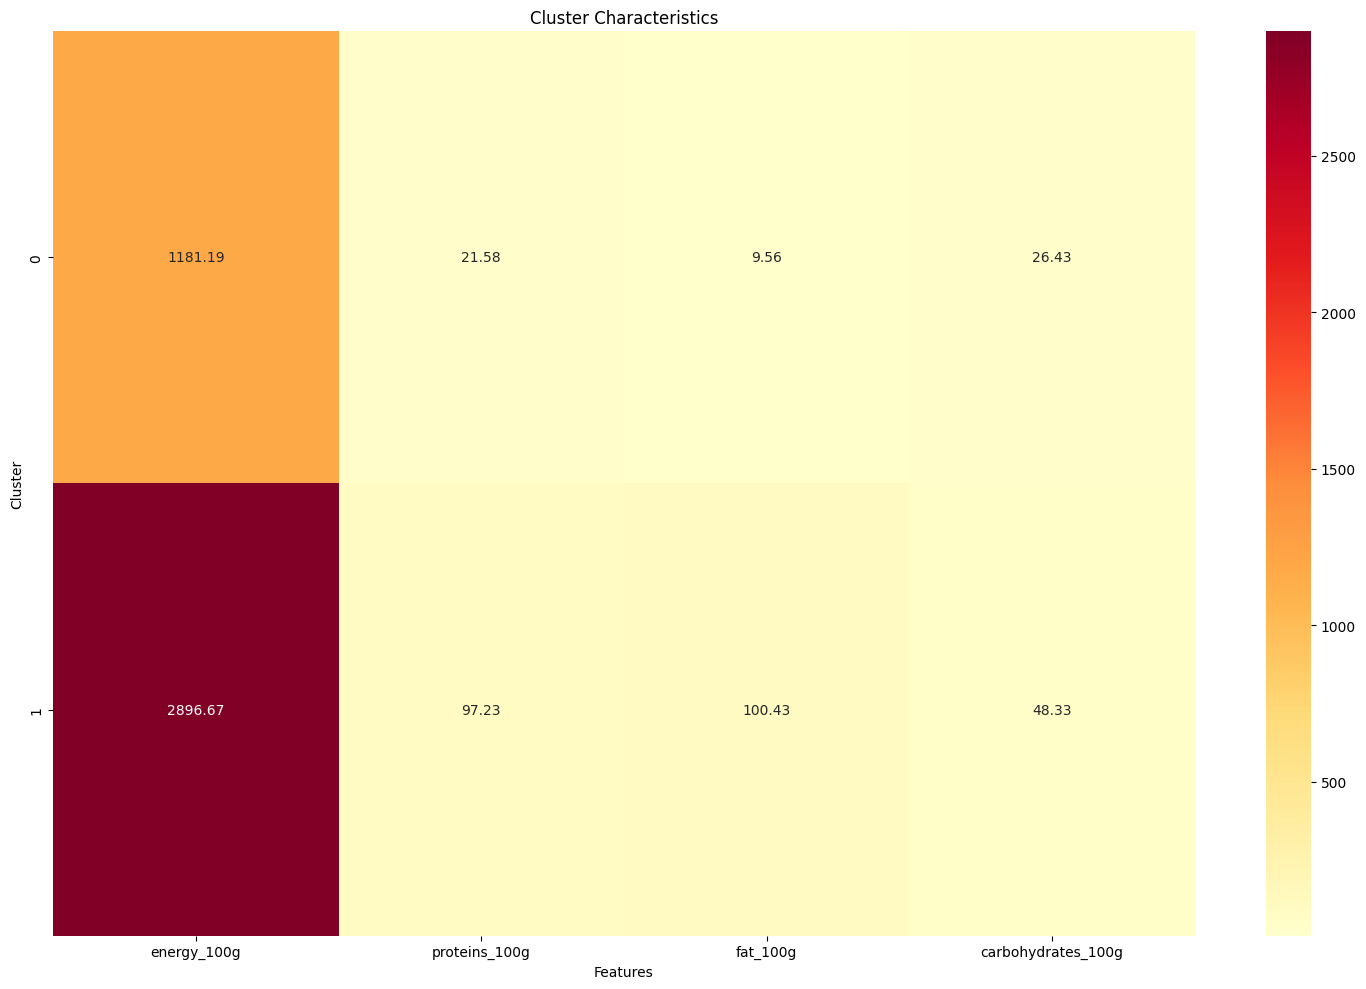


K-means Clustering Results:
------------------------------
Optimal number of clusters: 2
Silhouette score: 0.7772
Calinski-Harabasz score: 47.2587

Cluster Sizes:
------------------------------
Cluster 0: 97 products (97.0%)
Cluster 1: 3 products (3.0%)

Cluster Characteristics:
------------------------------
         energy_100g  proteins_100g  fat_100g  carbohydrates_100g
cluster                                                          
0        1181.189941      21.580000      9.56           26.430000
1        2896.669922      97.230003    100.43           48.330002


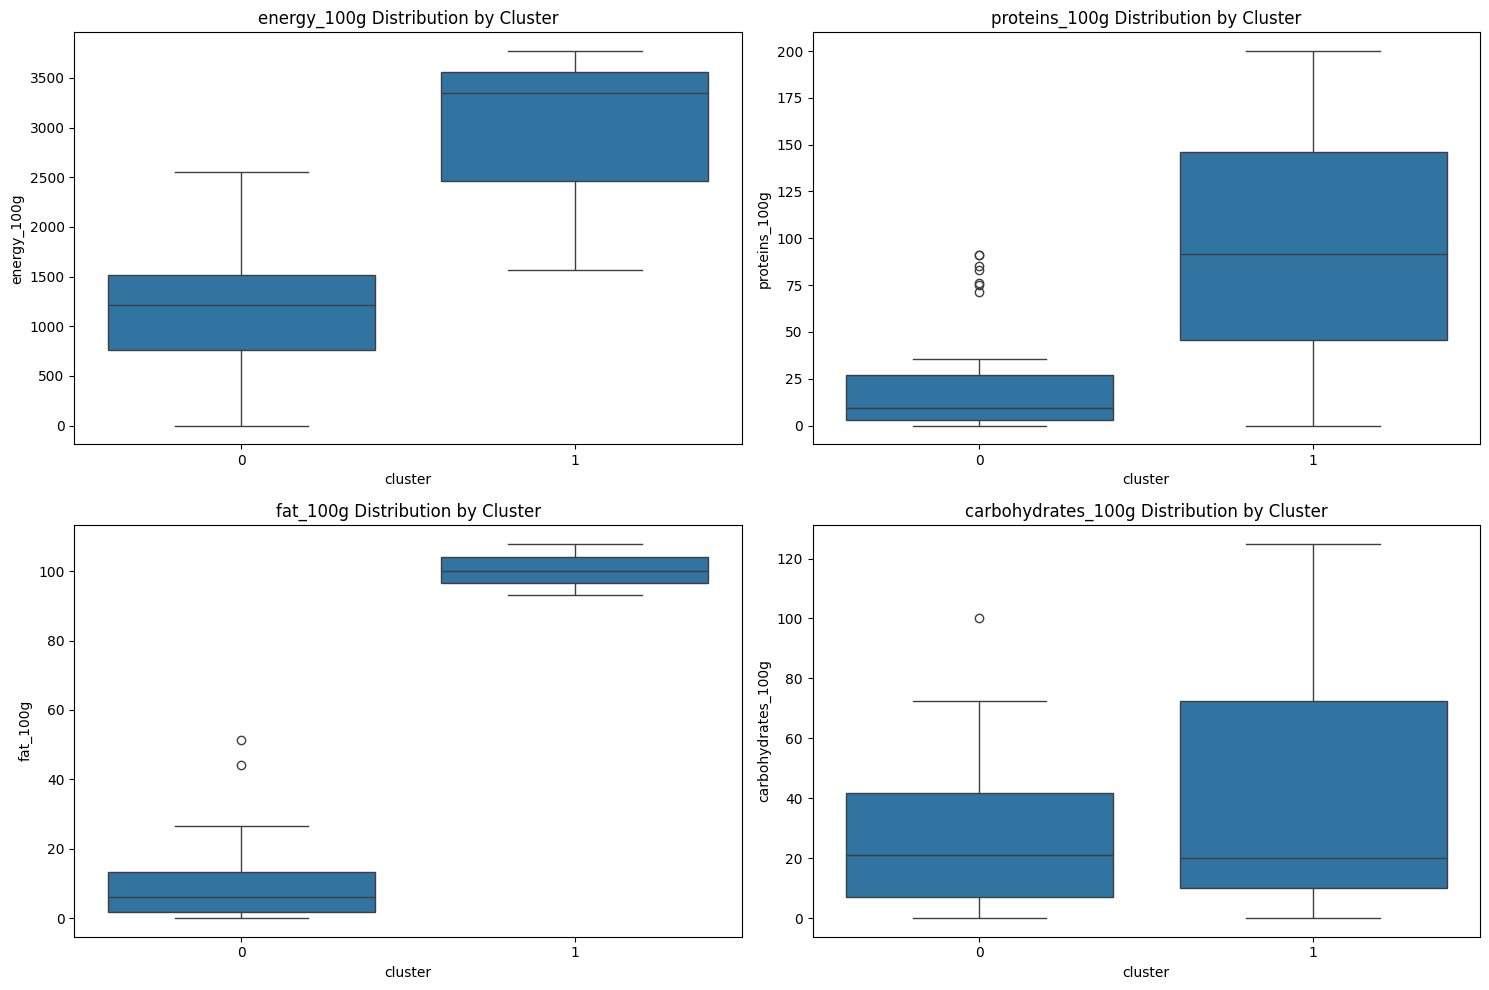

In [6]:
# Choix des features
features = ['energy_100g', 'proteins_100g', 'fat_100g', 'carbohydrates_100g']

# Train K-means avec plusieurs nbs de clusters
kmeans_model, metrics, df_clustered = train_kmeans(
    df, 
    features=features,
    n_clusters_range=range(2, 21),  # Max 20 clusters
    random_state=42
)

# print metrics
print("\nK-means Clustering Results:")
print("-" * 30)
print(f"Optimal number of clusters: {metrics['optimal_n_clusters']}")
print(f"Silhouette score: {metrics['silhouette_score']:.4f}")
print(f"Calinski-Harabasz score: {metrics['calinski_harabasz_score']:.4f}")

# Analyse des tailles des clusters
print("\nCluster Sizes:")
print("-" * 30)
cluster_sizes = df_clustered['cluster'].value_counts().sort_index()
for cluster, size in cluster_sizes.items():
    print(f"Cluster {cluster}: {size} products ({size/len(df_clustered)*100:.1f}%)")

# Analyse des caracteristiques des clusters
print("\nCluster Characteristics:")
print("-" * 30)
cluster_means = df_clustered.groupby('cluster')[features].mean()
print(cluster_means.round(2))

# Plots
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='cluster', y=feature, data=df_clustered)
    plt.title(f'{feature} Distribution by Cluster')
plt.tight_layout()
plt.show()

### A partir du format parquet 

parquet est un format optimisé pour la maniupulation de gros data set

on peut charger le data set sous ce format, à partir de [son emplacement sur HuggingFace](https://huggingface.co/datasets/openfoodfacts/product-database) (attention il faudra installer les librairies suivantes pour cela) 

Si ca n'est pas déja fait, télécharger les librairies nécessaires : 
```
pip install huggingface-hub
pip fastparquet

```

In [7]:
# Login using e.g. `huggingface-cli login` to access this dataset
splits = {'food': 'food.parquet', 'beauty': 'beauty.parquet'}
df = pd.read_parquet("hf://datasets/openfoodfacts/product-database/" + splits["food"])

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.

### Autres méthodes

Pour des détails complets sur les différentes options pour charger les données, consultez la [page dédiée du projet](https://world.openfoodfacts.org/data)